In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


#theano imports. Setting up to use CPU
%env THEANO_FLAGS='device=cpu'
import theano
import lasagne

env: THEANO_FLAGS='device=cpu'


# This tutorial explains the basic pipeline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup

Load a simple experiment environment and print its description

In [2]:
import agentnet.experiments.boolean_reasoning as experiment
# instantiate an experiment environment with default parameters
env = experiment.BooleanReasoningEnvironment()

print(experiment.__doc__)


Boolean reasoning is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1, X2, X3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 is true if X1
 - Y2 is true if not X1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will learn the policy
1. Check X1
2. If X1, check Y1, else Y2

Th

# Agent setup
* An agent implementation has to contain three parts:
  * Memory layer(s)
    * in this case, a single one-step RNN
  * Q-values evaluation layers
    * in this case, a lasagne dense layer based on memory layer
  * Resolver - an action picker layer
    * in this case, the resolver has epsilon-greedy policy

In [3]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory.rnn import RNNCell
from agentnet.agent import Agent

In [4]:
# hidden neurons
n_hidden_neurons = 64

observation_size = (None,) + tuple(env.observation_shapes)

observation_layer = lasagne.layers.InputLayer(observation_size, name="observation_input")
prev_state_layer = lasagne.layers.InputLayer([None, n_hidden_neurons], name="prev_state_input")

# memory layer (this isn't the same as lasagne recurrent units)
rnn = RNNCell(prev_state_layer, observation_layer, name="rnn0")

# q_values (estimated using very simple neural network)
q_values = lasagne.layers.DenseLayer(rnn,
                                     num_units=env.n_actions,
                                     nonlinearity=lasagne.nonlinearities.linear,
                                     name="QEvaluator")

# resolver uses epsilon - parameter which defines a probability of randomly taken action.
epsilon = theano.shared(np.float32(0.1), name="e-greedy.epsilon")
resolver = EpsilonGreedyResolver(q_values, epsilon=epsilon, name="resolver")


# packing this into agent
agent = Agent(observation_layer,
              agent_states={rnn:prev_state_layer},
              policy_estimators=q_values, 
              action_layers=resolver)

In [5]:
# Since it's a lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[rnn0.hid_to_hid.W,
 rnn0.hid_to_hid.b,
 rnn0.input0_to_hid.W,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

## Interacting with environment
* an agent has a method that produces __symbolic__ environment interaction sessions
* such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
  * environment implements an indicator of whether session has ended by current tick
* since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [6]:
# produce interaction sequences of length <= 10
(state_seq,), observation_seq, agent_state, action_seq, qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)

hidden_seq = agent_state[rnn]

# get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq, action_seq)

# get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)

## Defining loss function

Loss consists of two terms
- training error on played games
    - in our case, this loss is provided by Q-learning
- regularization

In [7]:
# get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

# gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(1), name='q_learning_gamma')

squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma)

# take sum over steps, average over sessions
mse_Qloss = squarred_Qerror.sum(axis=1).mean()

In [8]:
# impose l2 regularization on network weights
from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver, l2) * 10**-3

loss = mse_Qloss + reg_l2

## Compile train and evaluation functions

In [9]:
# compute weight updates
updates = lasagne.updates.adadelta(loss, weights, learning_rate=0.1)
# take sum over steps, average over sessions
mean_session_reward = rewards_seq.sum(axis=1).mean()

train_fun = theano.function([], [loss, mean_session_reward], updates=updates)

compute_mean_session_reward = theano.function([], mean_session_reward)

## Training loop

In [10]:
from agentnet.display import Metrics
score_log = Metrics()

In [11]:
batch_size = 10

for epoch in range(5000):        
    
    # update resolver's epsilon (chance of random action instead of optimal one)
    # epsilon decreases over time
    current_epsilon = 0.05 + 0.95 * np.exp(-epoch / 2500.)
    resolver.epsilon.set_value(np.float32(current_epsilon))
    
    # train
    env.generate_new_data_batch(batch_size)
    loss, avg_reward = train_fun()
        
    # show current learning progress
    if epoch % 100 == 0:
        print epoch,
        
        # estimate reward for epsilon-greedy strategy
        avg_reward_current = compute_mean_session_reward()
        score_log["expected epsilon-greedy reward"][epoch] = avg_reward_current
        
        # estimating the reward under assumption of greedy strategy
        resolver.epsilon.set_value(0)
        avg_reward_greedy = compute_mean_session_reward()
        score_log["expected greedy reward"][epoch] = avg_reward_greedy

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900


## Evaluate results

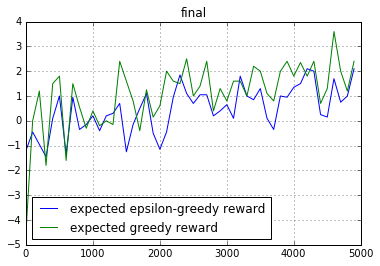

In [12]:
score_log.plot("final")

## Conclusion

We've trained out first agent which plays a fairly trivial game and learned a bit about basic agent structure. 

To dive deeper into AgentNet, please follow other tutorials.